# PREDICTION - EMISSIONS DE GAZ

Dans ce Notebook, nous nous concentrerons sur les émissions de gaz à effets de serre.  
Target = 'TotalGHGEmissions'

In [1]:
# Importation des modules requis
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os
import time
import shap

# Graphiques
from pandas.plotting import scatter_matrix
from matplotlib.collections import LineCollection

# Pre processing (normalisation et encodage)
from sklearn.preprocessing import *
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, PowerTransformer, OrdinalEncoder, RobustScaler, FunctionTransformer
from category_encoders.target_encoder import TargetEncoder

#feature importance
from sklearn.datasets import load_boston
from sklearn.inspection import permutation_importance

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

# Modèles
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.metrics import *

from sklearn import set_config

warnings.filterwarnings('ignore')

In [2]:
# Ouverture du Dataset
path_file = 'cleaned_dataset.csv'
dfdata = pd.read_csv(path_file, error_bad_lines=False, low_memory=False)
dfdata.head()

,Unnamed: 0,BuildingType,PrimaryPropertyType,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,...,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Age,prop_GFAParking,prop_Use1,prop_Use2,prop_Use3
0,0,NonResidential,Hotel,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1.0,...,88434,Hotel,60.0,7226362.5,249.98,89,0.000000,0.000000,0.000000,0.000000
1,1,NonResidential,Hotel,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1.0,...,103566,Hotel,61.0,8387933.0,295.86,20,0.145453,0.809918,0.145453,0.044629
2,2,NonResidential,Hotel,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1.0,...,956110,Hotel,43.0,72587024.0,2089.28,47,0.205748,0.000000,0.000000,0.000000
3,3,NonResidential,Hotel,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1.0,...,61320,Hotel,56.0,6794584.0,286.43,90,0.000000,0.000000,0.000000,0.000000
4,4,NonResidential,Hotel,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1.0,...,175580,Hotel,75.0,14172606.0,505.01,36,0.353115,0.644776,0.355224,0.000000


Text(0.5, 1.0, "Consommations d'énergie par ENERGYSTARScore et par BuildingType\n")

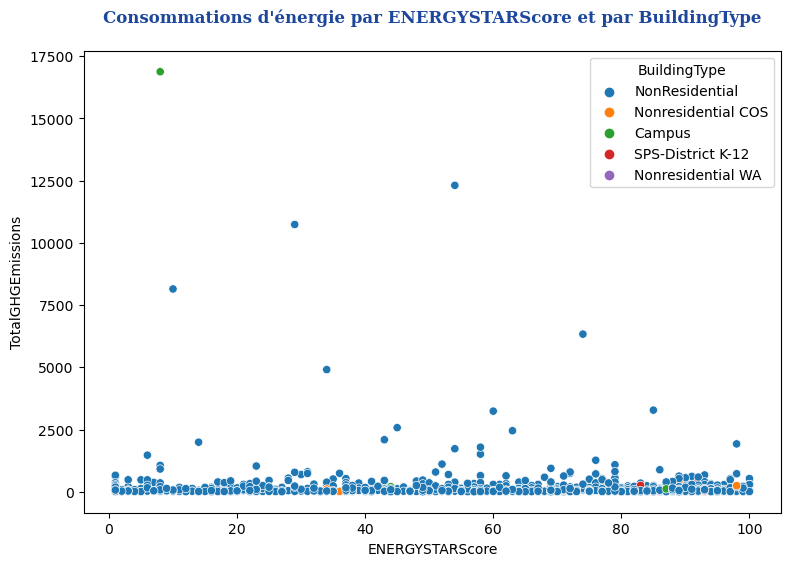

In [3]:
# Nuage de points Consommation d'énergie VS ENERGYSTARScore
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig = plt.figure(figsize=(9,6))
sns.scatterplot(data = dfdata, x='ENERGYSTARScore', y='TotalGHGEmissions', hue='BuildingType')
plt.title(f"Consommations d'énergie par ENERGYSTARScore et par BuildingType\n", 
          fontdict=font_title, fontsize=12)

On note ici qu'il n'y a pas de corrélation particulière entre ENERGYSTARScore et les émissions de gaz d'un bâtiment.

### Suppression colonnes inutiles / Définition target / Cleaning

In [4]:
cols_to_drop = ['Unnamed: 0',
                'SiteEnergyUse(kBtu)']

target = ['TotalGHGEmissions']

dfdata.drop(cols_to_drop,axis=1, inplace=True)
dfdata

,BuildingType,PrimaryPropertyType,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,TotalGHGEmissions,Age,prop_GFAParking,prop_Use1,prop_Use2,prop_Use3
0,NonResidential,Hotel,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1.0,12,88434,Hotel,60.0,249.98,89,0.000000,0.000000,0.000000,0.000000
1,NonResidential,Hotel,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1.0,11,103566,Hotel,61.0,295.86,20,0.145453,0.809918,0.145453,0.044629
2,NonResidential,Hotel,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1.0,41,956110,Hotel,43.0,2089.28,47,0.205748,0.000000,0.000000,0.000000
3,NonResidential,Hotel,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1.0,10,61320,Hotel,56.0,286.43,90,0.000000,0.000000,0.000000,0.000000
4,NonResidential,Hotel,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1.0,18,175580,Hotel,75.0,505.01,36,0.353115,0.644776,0.355224,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,NonResidential,Small- and Mid-Sized Office,98108.0,2824049007,2,GREATER DUWAMISH,47.53161,-122.29944,1.0,2,24990,Office,9.0,134.80,87,0.000000,0.000000,0.000000,0.000000
1519,NonResidential,Other,98155.0,0225049062,4,NORTHEAST,47.68109,-122.26180,1.0,1,72000,Other - Recreation,NaN,67.65,3,0.000000,0.000000,0.000000,0.000000
1520,NonResidential,K-12 School,98144.0,7548300840,3,GREATER DUWAMISH,47.58831,-122.30650,1.0,3,45000,K-12 School,77.0,9.24,1,0.000000,0.000000,0.000000,0.000000
1521,NonResidential,Mixed Use Property,98109.0,4088803385,7,LAKE UNION,47.62497,-122.33883,1.0,6,345290,Laboratory,NaN,1000.06,1,0.246251,0.443020,0.311377,0.245603


In [5]:
# Dernier contrôle des valeurs nulles
dfdata[dfdata.isna().any(axis=1)]

,BuildingType,PrimaryPropertyType,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,TotalGHGEmissions,Age,prop_GFAParking,prop_Use1,prop_Use2,prop_Use3
5,Nonresidential COS,Other,98101.0,0660000560,7,DOWNTOWN,47.61623,-122.33657,1.0,2,97288,Police Station,NaN,301.81,17,0.382349,0.000000,0.000000,0.000000
7,NonResidential,Other,98101.0,0660000955,7,DOWNTOWN,47.61327,-122.33136,1.0,8,102761,Other - Entertainment/Public Assembly,NaN,221.51,90,0.000000,0.000000,0.000000,0.000000
14,Nonresidential COS,Other,98154.0,0942000275,7,DOWNTOWN,47.60649,-122.33297,1.0,11,412000,Library,NaN,181.38,12,0.138350,0.879336,0.118076,0.002588
15,NonResidential,Other,98104.0,0942000350,7,DOWNTOWN,47.60546,-122.33279,1.0,6,103911,Fitness Center/Health Club/Gym,NaN,433.86,86,0.000000,0.692308,0.307692,0.000000
17,NonResidential,Mixed Use Property,98104.0,0942000510,7,DOWNTOWN,47.60515,-122.33159,1.0,5,57452,Social/Meeting Hall,NaN,273.02,109,0.000000,0.394406,0.371930,0.233664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,NonResidential,Mixed Use Property,98199.0,2771605298,7,MAGNOLIA / QUEEN ANNE,47.66144,-122.38723,1.0,2,25532,Office,NaN,4.38,2,0.000000,0.000000,0.000000,0.000000
1513,NonResidential,Other,98134.0,7666203255,2,GREATER DUWAMISH,47.58542,-122.32185,1.0,2,108036,Parking,NaN,91.98,1,0.000000,0.000000,0.000000,0.000000
1519,NonResidential,Other,98155.0,0225049062,4,NORTHEAST,47.68109,-122.26180,1.0,1,72000,Other - Recreation,NaN,67.65,3,0.000000,0.000000,0.000000,0.000000
1521,NonResidential,Mixed Use Property,98109.0,4088803385,7,LAKE UNION,47.62497,-122.33883,1.0,6,345290,Laboratory,NaN,1000.06,1,0.246251,0.443020,0.311377,0.245603


Les valeurs nulles restantes sont principalement dans la variable ENERGYSTARScore.  
Dans une première analyse, cette variable sera retirée.  
Dans la seconde partie, nous traiterons ces valeurs nulles.

#### Etudions le passage de la target y au log :

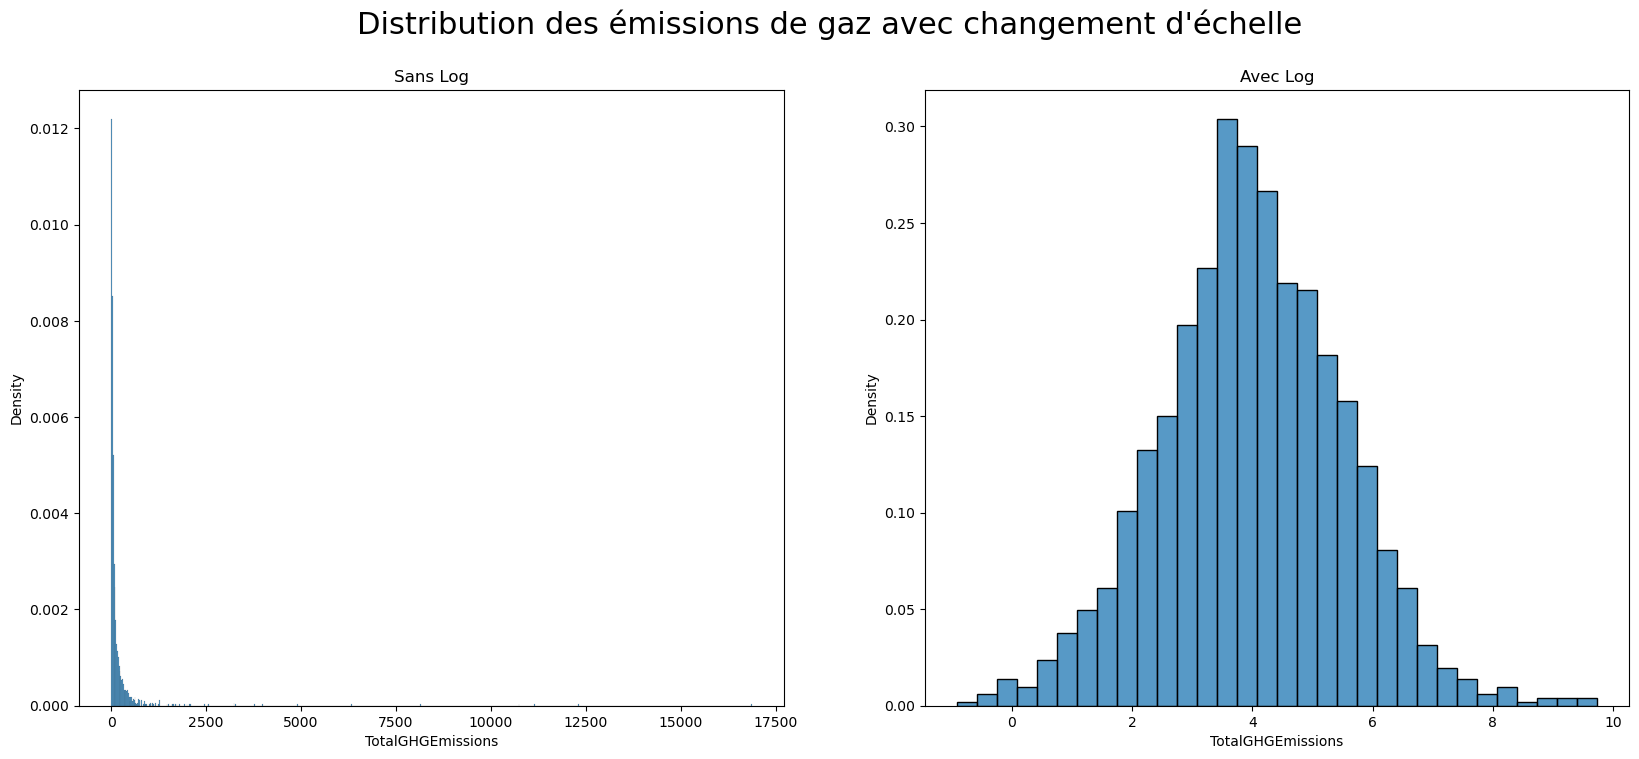

In [6]:
y_col = target
y = dfdata[y_col]
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
y_log = logtransformer.transform(y)
X = dfdata.drop(y, axis = 1)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=y, x='TotalGHGEmissions', stat="density", ax=axes[0])
axes[0].set_title("Sans Log")
sns.histplot(data=y_log, x='TotalGHGEmissions', stat="density", ax=axes[1])
axes[1].set_title("Avec Log")
plt.suptitle("Distribution des émissions de gaz avec changement d'échelle", fontsize=22)
plt.show()

#### Format du Dataset de modélisation :

In [7]:
print(" Format de X : {}".format(X.shape))
print(" Format de y : {}".format(y.shape))

 Format de X : (1523, 18)
 Format de y : (1523, 1)


#### Feature engineering (module preprocessing de ScikitLearn) :  
  
    - Variables quantitatives :  
        MinMaxScaler : normalise les données sur une échelle de 0 à 1, sensible aux outliers      
        RobustScaler : normalise les données en fonction des quartiles 1 et 3, peu sensible aux outliers  
        StandardScaler : chaque variable a une moyenne 0 et écart-type 1, sensible aux outliers  
      
    - Variables qualitatives :  
        Encodage One Hot  
            OneHotEncoder : chaque catégorie est représentée de façon binaire dans une colonne propre.     
            TargetEncoder : la probabilité d'occurence de chaque variable dans une seule colonnes.  
        Encodage ordinal  
            LabelEncoder : encodage d'une seule colonne (target), inutilisable ici.      
            OrdinaleEncoder : encodage pour plusieurs colonnes, inutilisable ici.

Nous utliserons le MinMaxScaler() pour les variables quantitatives, puis étudierons le OneHotEncoder() et le TargetEncoder() pour les variables qualitatives.

# 1. EMISSIONS DE GAZ - SANS ENERGYSTARSCORE

#### Suppression de la colonne ENERGYSTARScore

In [8]:
X.drop(['ENERGYSTARScore'], axis=1, inplace=True)

#### Définition des groupes de colonnes : quantitatives et qualitatives 

In [9]:
objectColumns = list(X.dtypes[dfdata.dtypes == np.object].index)
numericColumns = list(X.dtypes[dfdata.dtypes != np.object].index)
print("Variables qualitatives :\n {}".format(objectColumns))
print("")
print("Variables quantitatives :\n {}".format(numericColumns))
print("")
print("Target :\n {}".format(list(y.columns)))

Variables qualitatives :
 ['BuildingType', 'PrimaryPropertyType', 'TaxParcelIdentificationNumber', 'Neighborhood', 'LargestPropertyUseType']

Variables quantitatives :
 ['ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Age', 'prop_GFAParking', 'prop_Use1', 'prop_Use2', 'prop_Use3']

Target :
 ['TotalGHGEmissions']


#### Définition du train_set et du test_set (80 / 20)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2)

   ## A. MinMaxScaler + OneHotEncoder

#### Preprocessing

In [11]:
preprocessor = make_column_transformer((MinMaxScaler(),numericColumns),(OneHotEncoder(handle_unknown = 'ignore'),objectColumns))

#### Modélisation avec pipeline

In [12]:
results = []
algos = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol=0.5),
    'ElasticNet' : ElasticNet(),
    'SVR' : SVR(kernel='rbf'),
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor()
}

X_train, X_test, y_train_all, y_test_all = train_test_split(X, y_log, test_size=0.2, random_state=1)

In [13]:
for algo_name, algo in algos.items():
    start = time.time()
    y_test = y_test_all
    y_train = y_train_all
    model = make_pipeline(preprocessor,algo)
    model.fit(X_train,y_train)
    stop = time.time()
    chrono = round(stop - start,2)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, model.predict(X_test))
    results.append([mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred), r2, chrono])
    
    
dfresults = pd.DataFrame(results, index =[
    'LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SVR', 'RandomForest', 'XGBoost'], 
                         columns =['MAE', 'RMSE', 'Med Abs error', 'R2', 'Chrono (s)'])    
display(dfresults)

,MAE,RMSE,Med Abs error,R2,Chrono (s)
LinearRegression,9.411928,19.291580,4.935762,-145.104548,0.10
Ridge,0.969038,1.284966,0.730828,0.351796,0.01
Lasso,1.236434,1.596360,1.058407,-0.000438,0.01
ElasticNet,1.236434,1.596360,1.058407,-0.000438,0.01
SVR,0.960642,1.270402,0.680248,0.366407,0.07
RandomForest,0.846134,1.092708,0.683847,0.531255,1.71
XGBoost,0.841282,1.107260,0.652392,0.518687,0.09


#### Crossvalidation

Selon les résultats de la modélisation ci-dessus, nous n'appliquerons la cross validation que sur les modèles pertinents :  
- RandomForest  
- XGBoost

In [14]:
# Crossvalidation : RandomForest
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [15]:
model = make_pipeline(preprocessor,RandomForestRegressor())
parameters = {
    'randomforestregressor__n_estimators':[10,100,500], 
    'randomforestregressor__bootstrap':[True,False], 
    'randomforestregressor__ccp_alpha':[0,0.01,0.001]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: RandomForest MinMaxScaler OneHotEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: RandomForest MinMaxScaler OneHotEncoder
Best score :  0.5131798134458735
Best parameters :  {'randomforestregressor__bootstrap': True, 'randomforestregressor__ccp_alpha': 0, 'randomforestregressor__n_estimators': 500}
score de la prédiction: 0.935433282331906
RMSE =  0.843696589743278
MAE =  1.094273193061022
median abs err =  0.6881095207603223


In [16]:
# Crossvalidation : LXGBoostRegressor
XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [17]:
model = make_pipeline(preprocessor,XGBRegressor())
parameters = {
    'xgbregressor__n_estimators':[10,100,500], 
    'xgbregressor__enable_categorical':[True,False], 
    'xgbregressor__learning_rate':[0.1,0.3,0.5]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: XGBoost MinMaxScaler OneHotEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: XGBoost MinMaxScaler OneHotEncoder
Best score :  0.5236032675189353
Best parameters :  {'xgbregressor__enable_categorical': False, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__n_estimators': 100}
score de la prédiction: 0.8225663869971356
RMSE =  0.8423608695857064
MAE =  1.0993635675168434
median abs err =  0.6744009424644624


## B. MinMaxScaler + TargetEncoder

#### Preprocessing

In [18]:
preprocessor = make_column_transformer((MinMaxScaler(),numericColumns),(TargetEncoder(),objectColumns))

#### Modélisation avec pipeline

In [19]:
results2 = []
algos = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol=0.5),
    'ElasticNet' : ElasticNet(),
    'SVR' : SVR(kernel='rbf'),
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor()
}

X_train, X_test, y_train_all, y_test_all = train_test_split(X, y_log, test_size=0.2, random_state=1)

In [20]:
for algo_name, algo in algos.items():
    start = time.time()
    y_test = y_test_all
    y_train = y_train_all
    model = make_pipeline(preprocessor,algo)
    model.fit(X_train,y_train)
    stop = time.time()
    chrono = round(stop - start,2)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, model.predict(X_test))
    results2.append([mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred), r2, chrono])
    
    
dfresults2 = pd.DataFrame(results2, index =[
    'LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SVR', 'RandomForest', 'XGBoost'], 
                         columns =['MAE', 'RMSE', 'Med Abs error', 'R2', 'Chrono (s)'])    
display(dfresults2)

,MAE,RMSE,Med Abs error,R2,Chrono (s)
LinearRegression,1.200805,1.545135,1.043950,0.062738,0.04
Ridge,1.187753,1.531157,1.028692,0.079619,0.03
Lasso,1.236434,1.596360,1.058407,-0.000438,0.03
ElasticNet,1.207707,1.565489,1.019920,0.037882,0.04
SVR,1.091597,1.427201,0.854789,0.200353,0.07
RandomForest,1.169558,1.505489,0.991421,0.110218,0.43
XGBoost,1.191233,1.533635,0.982395,0.076637,0.08


Selon les résultats de la modélisation ci-dessus, nous n'appliquerons la cross validation que sur les modèles pertinents :  
- RandomForest  
- XGBoost

#### Crossvalidation

In [21]:
# Crossvalidation : RandomForest
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [22]:
model = make_pipeline(preprocessor,RandomForestRegressor())
parameters = {
    'randomforestregressor__n_estimators':[10,100,500], 
    'randomforestregressor__bootstrap':[True,False], 
    'randomforestregressor__ccp_alpha':[0,0.01,0.001]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: RandomForest MinMaxScaler TargetEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: RandomForest MinMaxScaler TargetEncoder
Best score :  0.07384596091901521
Best parameters :  {'randomforestregressor__bootstrap': False, 'randomforestregressor__ccp_alpha': 0.001, 'randomforestregressor__n_estimators': 100}
score de la prédiction: 0.984912728995519
RMSE =  1.1452772207950344
MAE =  1.47389324564602
median abs err =  0.937067082044154


In [23]:
# Crossvalidation : LXGBoostRegressor
XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [24]:
model = make_pipeline(preprocessor,XGBRegressor())
parameters = {
    'xgbregressor__n_estimators':[10,100,500], 
    'xgbregressor__enable_categorical':[True,False], 
    'xgbregressor__learning_rate':[0.1,0.3,0.5]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: XGBoost MinMaxScaler TargetEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: XGBoost MinMaxScaler TargetEncoder
Best score :  0.03620589401537999
Best parameters :  {'xgbregressor__enable_categorical': False, 'xgbregressor__learning_rate': 0.5, 'xgbregressor__n_estimators': 500}
score de la prédiction: 0.9999994170268053
RMSE =  1.1945100088957097
MAE =  1.5390439437660892
median abs err =  1.0023606081101852


# 2. EMISSIONS DE GAZ - AVEC ENERGYSTARSCORE

#### Imputation de la colonne ENERGYSTARScore pour les valeurs nulles

In [25]:
# Remplissage avec médiane
dfdata['ENERGYSTARScore'] = dfdata['ENERGYSTARScore'].fillna(dfdata['ENERGYSTARScore'].median())

In [26]:
# Nous redéfinissons la dataframe initiale pour la modélisation
y_col = target
y = dfdata[y_col]
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
y_log = logtransformer.transform(y)
X = dfdata.drop(y, axis = 1)

#### Définition des groupes de colonnes : quantitatives et qualitatives 

In [27]:
objectColumns = list(X.dtypes[dfdata.dtypes == np.object].index)
numericColumns = list(X.dtypes[dfdata.dtypes != np.object].index)
print("Variables qualitatives :\n {}".format(objectColumns))
print("")
print("Variables quantitatives :\n {}".format(numericColumns))
print("")
print("Target :\n {}".format(list(y.columns)))

Variables qualitatives :
 ['BuildingType', 'PrimaryPropertyType', 'TaxParcelIdentificationNumber', 'Neighborhood', 'LargestPropertyUseType']

Variables quantitatives :
 ['ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore', 'Age', 'prop_GFAParking', 'prop_Use1', 'prop_Use2', 'prop_Use3']

Target :
 ['TotalGHGEmissions']


#### Définition du train_set et du test_set (80 / 20)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2)

   ## A. MinMaxScaler + OneHotEncoder

#### Preprocessing

In [29]:
preprocessor = make_column_transformer((MinMaxScaler(),numericColumns),(OneHotEncoder(handle_unknown = 'ignore'),objectColumns))

#### Modélisation avec pipeline

In [30]:
results3 = []
algos = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol=0.5),
    'ElasticNet' : ElasticNet(),
    'SVR' : SVR(kernel='rbf'),
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor()
}

X_train, X_test, y_train_all, y_test_all = train_test_split(X, y_log, test_size=0.2, random_state=1)

In [31]:
for algo_name, algo in algos.items():
    start = time.time()
    y_test = y_test_all
    y_train = y_train_all
    model = make_pipeline(preprocessor,algo)
    model.fit(X_train,y_train)
    stop = time.time()
    chrono = round(stop - start,2)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, model.predict(X_test))
    results3.append([mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred), r2, chrono])
    
    
dfresults3 = pd.DataFrame(results3, index =[
    'LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SVR', 'RandomForest', 'XGBoost'], 
                         columns =['MAE', 'RMSE', 'Med Abs error', 'R2', 'Chrono (s)'])    
display(dfresults3)

,MAE,RMSE,Med Abs error,R2,Chrono (s)
LinearRegression,9.803755,20.463313,5.154687,-163.391748,0.10
Ridge,0.945356,1.254068,0.668115,0.382595,0.01
Lasso,1.236434,1.596360,1.058407,-0.000438,0.01
ElasticNet,1.236434,1.596360,1.058407,-0.000438,0.01
SVR,0.942501,1.249959,0.664262,0.386634,0.07
RandomForest,0.826181,1.055066,0.664458,0.562994,1.79
XGBoost,0.822015,1.068969,0.621908,0.551401,0.09


#### Crossvalidation

Selon les résultats de la modélisation ci-dessus, nous n'appliquerons la cross validation que sur les modèles pertinents :  
- RandomForest  
- XGBoost

In [32]:
# Crossvalidation : RandomForest
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [33]:
model = make_pipeline(preprocessor,RandomForestRegressor())
parameters = {
    'randomforestregressor__n_estimators':[10,100,500], 
    'randomforestregressor__bootstrap':[True,False], 
    'randomforestregressor__ccp_alpha':[0,0.01,0.001]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: RandomForest MinMaxScaler OneHotEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: RandomForest MinMaxScaler OneHotEncoder
Best score :  0.5262852220033308
Best parameters :  {'randomforestregressor__bootstrap': True, 'randomforestregressor__ccp_alpha': 0.001, 'randomforestregressor__n_estimators': 500}
score de la prédiction: 0.9105238568419605
RMSE =  0.8178759183241316
MAE =  1.0523293166099568
median abs err =  0.6831894749619485


In [34]:
# Crossvalidation : LXGBoostRegressor
XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [35]:
model = make_pipeline(preprocessor,XGBRegressor())
parameters = {
    'xgbregressor__n_estimators':[10,100,500], 
    'xgbregressor__enable_categorical':[True,False], 
    'xgbregressor__learning_rate':[0.1,0.3,0.5]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: XGBoost MinMaxScaler OneHotEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: XGBoost MinMaxScaler OneHotEncoder
Best score :  0.5321489679216147
Best parameters :  {'xgbregressor__enable_categorical': False, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__n_estimators': 100}
score de la prédiction: 0.8482925205010934
RMSE =  0.8322323754166069
MAE =  1.0660797413178695
median abs err =  0.700224986462147


#### Feature importance

In [36]:
model = make_pipeline(preprocessor,XGBRegressor())

In [37]:
model = XGBRegressor()
X_ = pd.get_dummies(X, drop_first=True)
col_names = X_.columns
X_ = pd.DataFrame(MinMaxScaler().fit_transform(X_), columns = col_names)
model.fit(X_,y_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

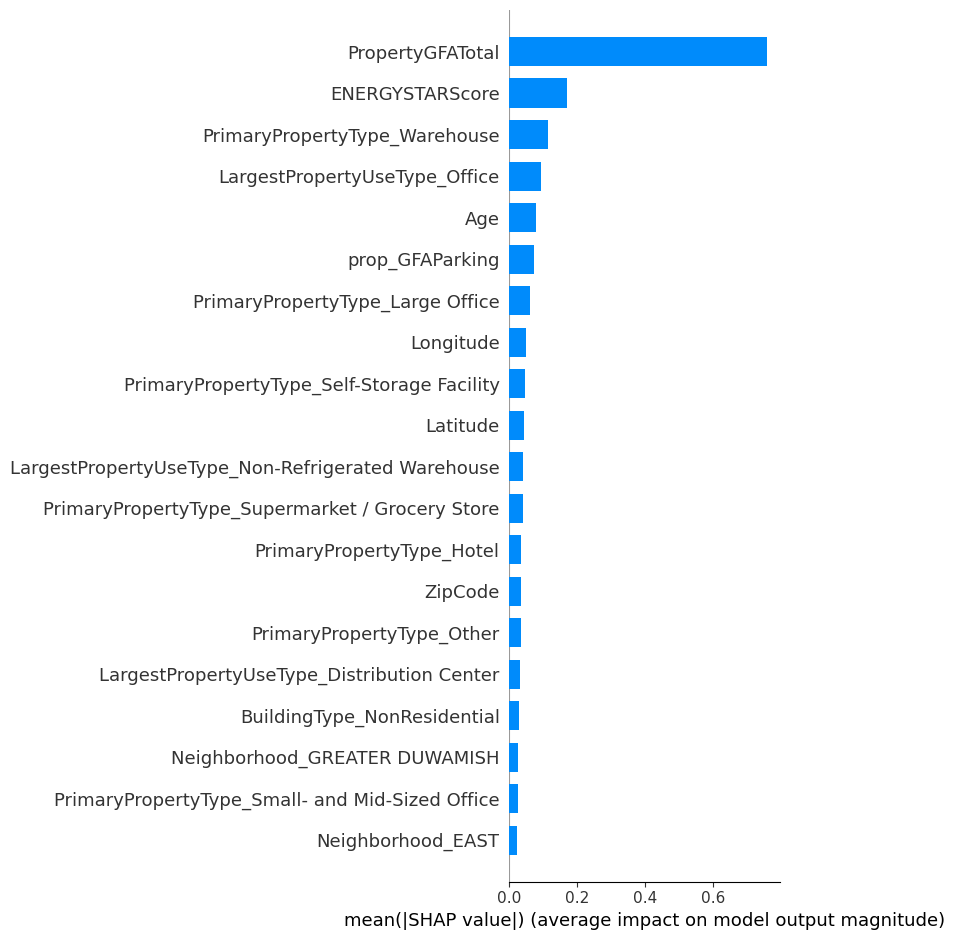

In [38]:
shap_values = shap.TreeExplainer(model).shap_values(X_)
shap.summary_plot(shap_values, X_, plot_type="bar")

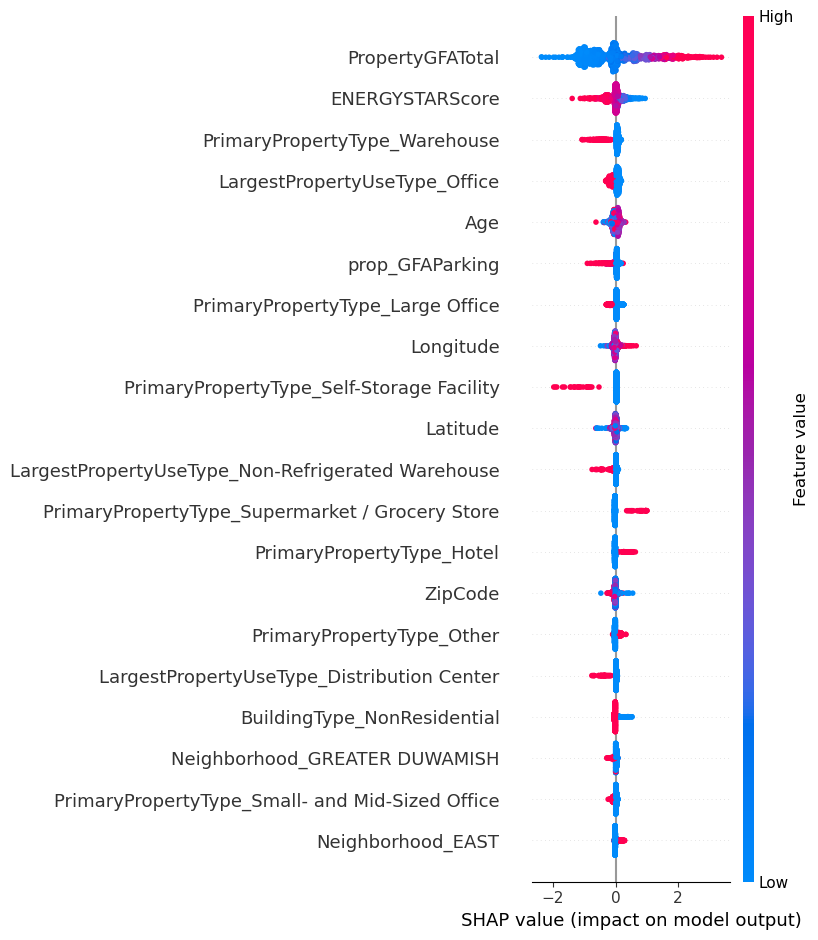

In [39]:
shap.summary_plot(shap_values, X_)

## B. MinMaxScaler + TargetEncoder

#### Preprocessing

In [40]:
preprocessor = make_column_transformer((MinMaxScaler(),numericColumns),(TargetEncoder(),objectColumns))

#### Modélisation avec pipeline

In [41]:
results4 = []
algos = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol=0.5),
    'ElasticNet' : ElasticNet(),
    'SVR' : SVR(kernel='rbf'),
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor()
}

X_train, X_test, y_train_all, y_test_all = train_test_split(X, y_log, test_size=0.2, random_state=1)

In [42]:
for algo_name, algo in algos.items():
    start = time.time()
    y_test = y_test_all
    y_train = y_train_all
    model = make_pipeline(preprocessor,algo)
    model.fit(X_train,y_train)
    stop = time.time()
    chrono = round(stop - start,2)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, model.predict(X_test))
    results4.append([mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred), r2, chrono])
    
    
dfresults4 = pd.DataFrame(results4, index =[
    'LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SVR', 'RandomForest', 'XGBoost'], 
                         columns =['MAE', 'RMSE', 'Med Abs error', 'R2', 'Chrono (s)'])    
display(dfresults4)

,MAE,RMSE,Med Abs error,R2,Chrono (s)
LinearRegression,1.199305,1.543251,1.042681,0.065022,0.03
Ridge,1.184851,1.527457,1.031049,0.084061,0.03
Lasso,1.236434,1.596360,1.058407,-0.000438,0.03
ElasticNet,1.207707,1.565489,1.019920,0.037882,0.03
SVR,1.080114,1.411379,0.848014,0.217985,0.07
RandomForest,1.168945,1.505473,0.982361,0.110238,0.45
XGBoost,1.189042,1.525208,0.970668,0.086758,0.08


Selon les résultats de la modélisation ci-dessus, nous n'appliquerons la cross validation que sur les modèles pertinents :  
- RandomForest  
- XGBoost

#### Crossvalidation

In [43]:
# Crossvalidation : RandomForest
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [44]:
model = make_pipeline(preprocessor,RandomForestRegressor())
parameters = {
    'randomforestregressor__n_estimators':[10,100,500], 
    'randomforestregressor__bootstrap':[True,False], 
    'randomforestregressor__ccp_alpha':[0,0.01,0.001]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: RandomForest MinMaxScaler TargetEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: RandomForest MinMaxScaler TargetEncoder
Best score :  0.07834611753401581
Best parameters :  {'randomforestregressor__bootstrap': False, 'randomforestregressor__ccp_alpha': 0.001, 'randomforestregressor__n_estimators': 500}
score de la prédiction: 0.9855443705352305
RMSE =  1.1414571384406524
MAE =  1.4689781589756017
median abs err =  0.9359405467561599


In [45]:
# Crossvalidation : LXGBoostRegressor
XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [46]:
model = make_pipeline(preprocessor,XGBRegressor())
parameters = {
    'xgbregressor__n_estimators':[10,100,500], 
    'xgbregressor__enable_categorical':[True,False], 
    'xgbregressor__learning_rate':[0.1,0.3,0.5]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: XGBoost MinMaxScaler TargetEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: XGBoost MinMaxScaler TargetEncoder
Best score :  0.039110870892028714
Best parameters :  {'xgbregressor__enable_categorical': False, 'xgbregressor__learning_rate': 0.5, 'xgbregressor__n_estimators': 100}
score de la prédiction: 0.9999863319167056
RMSE =  1.2020436527970997
MAE =  1.5447831280453772
median abs err =  0.9838304225906094


# CONCLUSION CONCERNANT LES PREDICTIONS D'EMISSIONS DE GAZ

#### ENERGYSTARScore :  
  
La modélisation en incluant cette variable donne de meilleurs résultats : 0.532 VS 0.523 (XGBoostRegressor via GridSearchCV).  En outre, celle-ci apparaît en deuxième position dans la représentation des features importances du modèle, ce qui montre son influence relativement importante sur le modèle.  
  
    
#### Encodage / Transformation :  
  
La méthode d'encodage affichant les meilleurs résultats est le OneHotEncoder couplé au MinMaxScaler.  
  
    
#### Modélisation :  
  
Le modèle affichant les meilleurs résultats est le XGBoostRegressor (best score : 0.532).  
En outre, ce modèle affiche un temps d'entraînement très inférieur au modèle RandomForest, ainsi qu'une RMSE légèrement plus élevée (0.84).      
Mis à part la variable ENERGYSTARScore, les variables ayant le plus d'influence sur notre modèle sont la surface totale, l'âge du bâtiment, le type d'utilisation ou encore la proportion du parking sur l'ensemble de la surface.